## **[How to Combine the Forecasts of an Ensemble](https://medium.com/towards-data-science/how-to-combine-the-forecasts-of-an-ensemble-11022e5cac25)**
### **Using dynamic forecasting ensembles to cope with changes in the time series**

We explored the main steps for building ensembles.

In this post:

- we dive deeper into forecasting ensembles;
- we discuss how ensembles combine many forecasts;
- we explore dynamic weighted averages for forecast combination;
- we apply a dynamic ensemble to a case study using Python

### **Introduction**

Combining the predictions of many models improves forecasting performance. These approaches can be further improved with **_dynamic combination rules_**.

There are many ways to build a forecasting ensemble. Yet, standard approaches do not consider the _dynamic nature of time series_.

In time series, things evolve over time due to the non-stationarities at play. For instance, different regimes or seasonal effects. These cause variability in relative performance. **_Different forecasting models perform better in different periods._**

This variability in performance should be reflected when combining forecasts. At each time step, each model should be weighted according to how you expect them to perform.

Ensembles that adapt their weights over time are called dynamic.

### **From Static to Dynamic Ensembles**

<center> <p>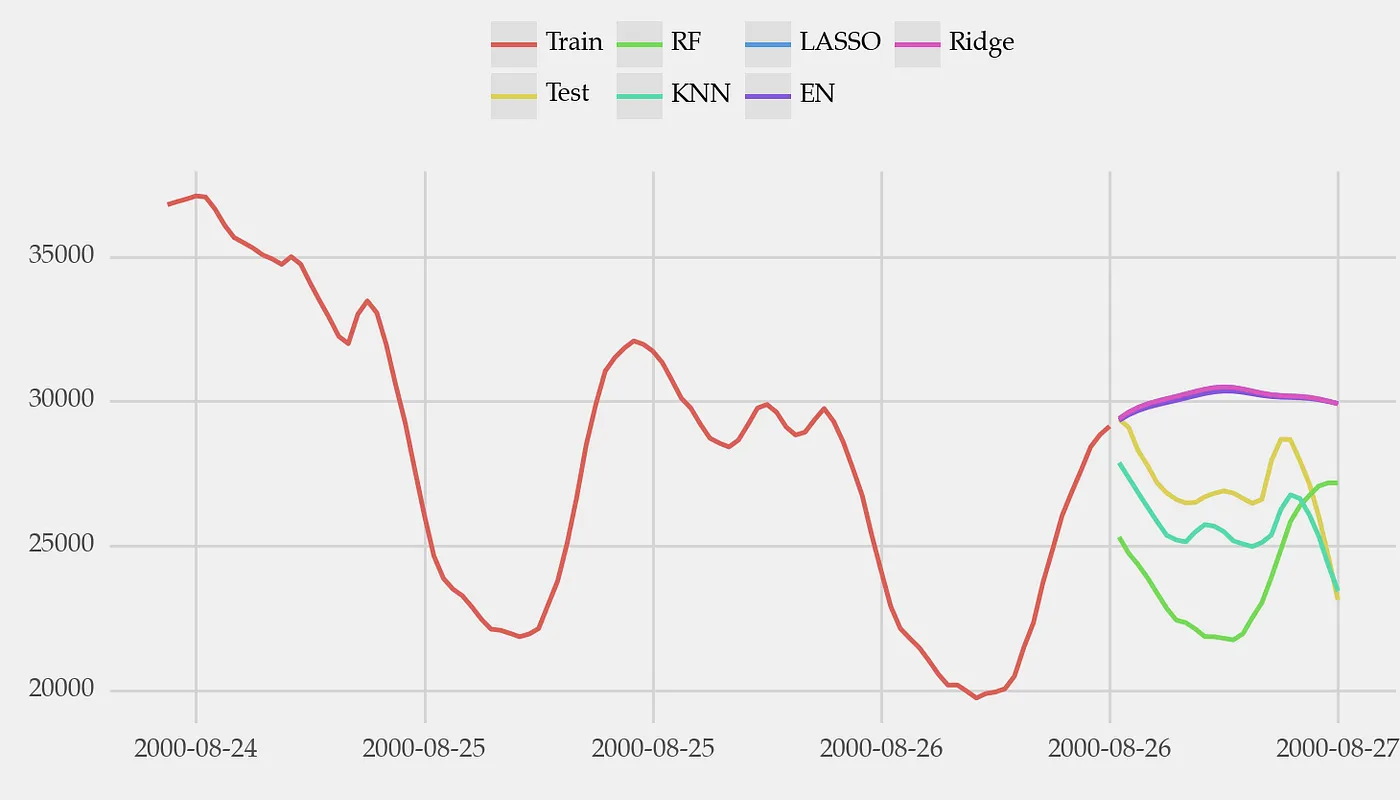</p> </center>

A time serires and the forecasts of several models

### **Constant weights**

Bagging, boosting, chaining, or stacking are a few examples of ensembles.

Bagging or boosting ensembles combine individual forecasts using a simple average. Thus, all models in the ensemble have equal weights. In stacking or chaining, the weights are not equal. The best combination rule is learned during training.

**_In any of these cases, the combination rule is static._** The weight of each model is the same at all times.

But, constant weights fail to adapt to changes in the time series. This issue is solved by dynamic combination rules.

### **Dynamic weights**

<center> <p>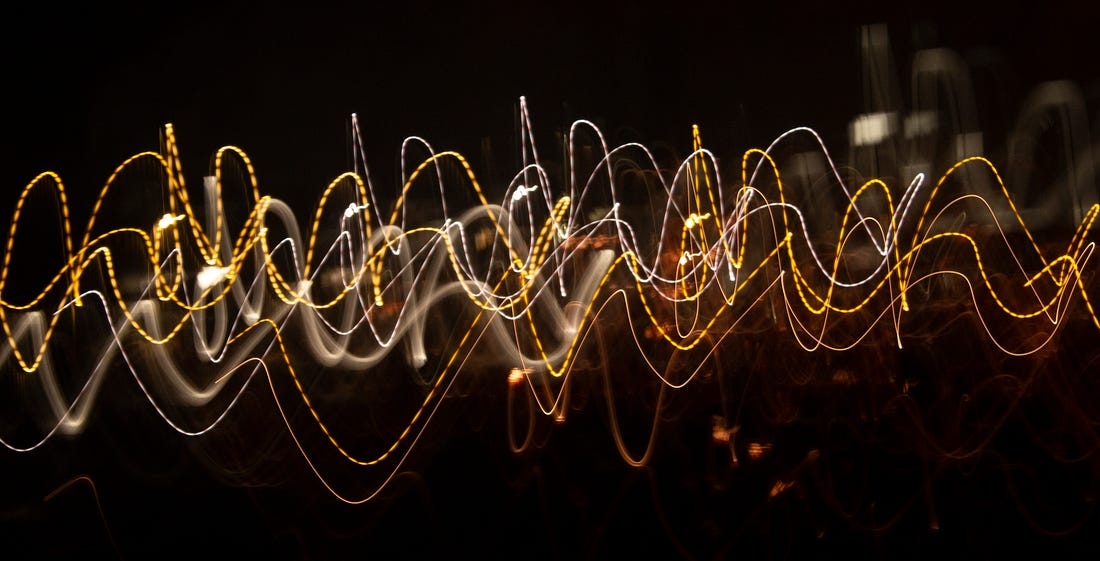</p> </center>

Ensembles with dynamic weights can cope with changes in time series.

The challenge becomes estimating which models are stronger in a given instant. Turns out, this is a thorny task. But, many approaches are available to solve it.

Dynamic ensembles fall into three possible categories:

- Windowing: the weights are computed based on model performance in a window of past recent data. For example, you can compute the rolling squared error. Then, at each instant, you get the weights by normalizing the error scores. You can find [an implementation of Windowing in my Github](https://github.com/vcerqueira/blog/blob/main/src/ensembles/windowing.py);  

- Regret minimization: Some methods attempt to minimize a metric called regret. Examples include the exponentially weighted average, the polynomially weighted average, or the fixed share aggregation. The second chapter of the book in reference [2] describes these methods in detail. You can also find their implementation in the R package opera.

- Meta-learning: Other techniques learn and predict the weights of each model for a given instant. [Arbitrating is an example of such a method](https://github.com/vcerqueira/blog/blob/main/src/ensembles/ade.py).

### **Case Study**
In the rest of this article, we’ll create a dynamic forecasting ensemble.

We’ll use a time series related to energy demand. Here’s how it looks:

<center> <p>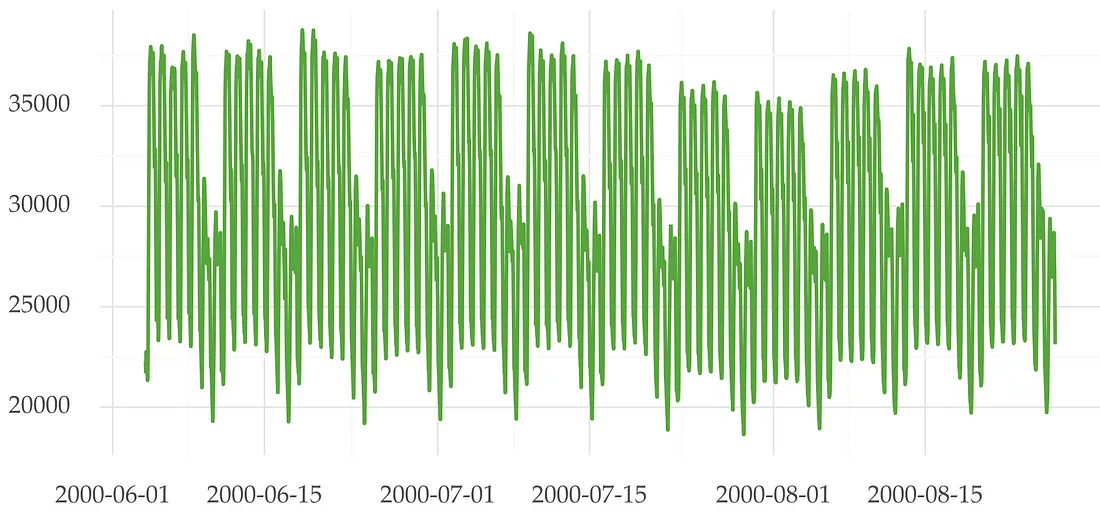</p> </center>

### **Building the Ensemble**

We start by transforming the time series for supervised learning. This is done using time delay embedding. You can check my previous post to learn more about this approach.

Then, we build the ensemble. Here’s the script to do this. Check the comments in the code for more context.

In [31]:

import sys
sys.path.insert(0, '../')

import pandas as pd
import warnings

warnings.filterwarnings('ignore')

# methods and validation split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNetCV

# time series example -- GPL-3 license
from pmdarima.datasets import load_taylor

# src module
from src.tde import time_delay_embedding

# loading the data
series = load_taylor(as_series=True)

# train test split
train, test = train_test_split(series, test_size=0.1, shuffle=False)

# ts for supervised learning
train_df = time_delay_embedding(train, n_lags=10, horizon=1).dropna()
test_df = time_delay_embedding(test, n_lags=10, horizon=1).dropna()

# creating the predictors and target variables
# the goal is to forecast the next observation of energy demand
X_train, y_train = train_df.drop('Series(t+1)', axis=1), train_df['Series(t+1)']
X_test, y_test = test_df.drop('Series(t+1)', axis=1), test_df['Series(t+1)']

# defining the five models composing the ensemble
models = {
    'RF': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'LASSO': Lasso(),
    'EN': ElasticNetCV(),
    'Ridge': Ridge(),
}

# training and getting predictions
train_forecasts, test_forecasts = {}, {}
for k in models:
    models[k].fit(X_train, y_train)
    train_forecasts[k] = models[k].predict(X_train)
    test_forecasts[k] = models[k].predict(X_test)

# predictions as pandas dataframe
ts_forecasts_df = pd.DataFrame(test_forecasts)
tr_forecasts_df = pd.DataFrame(train_forecasts)


In [32]:
print(f'train.shape: {tr_forecasts_df.shape}')
print(f'test.shape: {ts_forecasts_df.shape}')

train.shape: (3618, 5)
test.shape: (394, 5)


We’ve built an ensemble composed of five models: a Random Forest, a KNN, a LASSO, a Ridge, and an Elastic-net.

In the script above, we also store the training predictions of each model in a pd.DataFrame. In the first few instances, there’s little information for weighing the different models. So, the training predictions are useful for warm-starting the weight estimates.

### **Dynamic Combination Rule**

After building the ensemble, we’re ready to make a dynamic combination rule. We focus on two methods: windowing, and arbitrating. Besides these, we also include a static approach based on the simple average of forecasts.

In [33]:
# windowing 
from src.ensembles.windowing import WindowLoss
# arbitrating (a meta-learning strategy)
from src.ensembles.ade import Arbitrating

# combining training and testing predictions
forecasts_df = pd.concat([tr_forecasts_df, ts_forecasts_df], axis=0).reset_index(drop=True)
# combining training and testing observations
actual = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

# setting up windowloss dynamic combinatio rule
windowing = WindowLoss()
window_weights = windowing.get_weights(forecasts_df, actual)
window_weights = window_weights.tail(X_test.shape[0]).reset_index(drop=True)

# setting up arbitrating dynamic combinatio rule
arbitrating = Arbitrating()
arbitrating.fit(tr_forecasts_df, y_train, X_train)
arb_weights = arbitrating.get_weights(X_test)
arb_weights = arb_weights.tail(X_test.shape[0])

# weighting the ensemble dynamically
windowing_fh = (window_weights.values * ts_forecasts_df.values).sum(axis=1)
arbitrating_fh = (arb_weights.values * ts_forecasts_df.values).sum(axis=1)

# combining the models with static and equal weights (average)
static_average = ts_forecasts_df.mean(axis=1).values

The final forecast is a weighted average. This is done by multiplying the weights with the individual forecasts, followed by a sum operation.

Here’s the evolution of the weights of each model according to the windowing approach:



<Axes: >

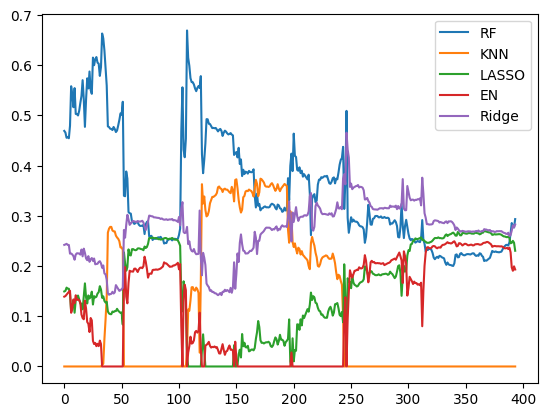

In [34]:
window_weights.plot()

Text(0.5, 1.0, 'Dynamic Ensemble weights from arbitrating')

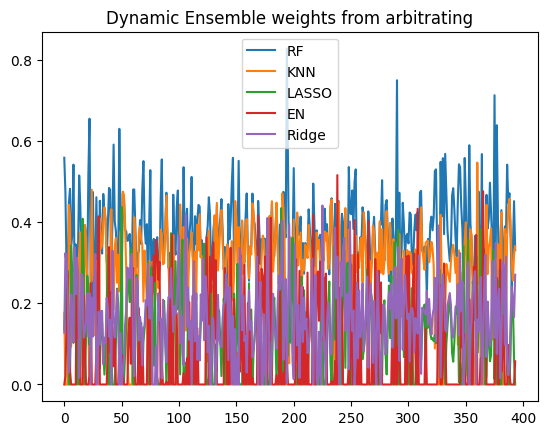

In [35]:
arb_weights.plot()
plt.title('Dynamic Ensemble weights from arbitrating')

Early on, the Random Forest (RF) is the most relevant model. But, Ridge becomes more important in the final part of the series.

Here’s the final error of each approach:

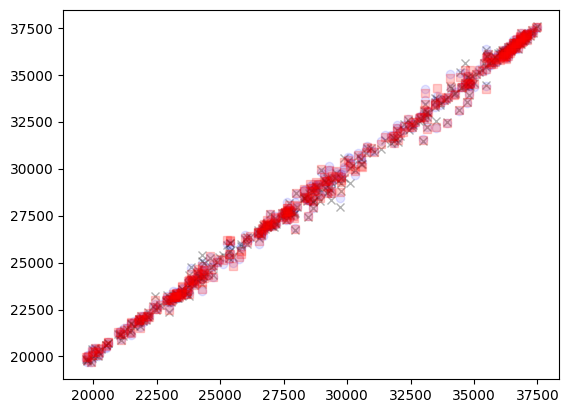

In [36]:
import matplotlib.pyplot as plt

plt.plot(y_test, windowing_fh, 'bo', alpha = 0.1)
plt.plot(y_test, arbitrating_fh, 'kx', alpha = 0.3)
plt.plot(y_test, static_average, 'rs', alpha = 0.2)
plt.show()

In [39]:
import numpy as np

def compute_error_metrics(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)), np.max(np.abs(y_true - y_pred))

print(compute_error_metrics(y_test, windowing_fh))
print(compute_error_metrics(y_test, arbitrating_fh))
print(compute_error_metrics(y_test, static_average))

(228.96635627548255, 1492.183745266946)
(221.95191006421967, 1763.7213043082556)
(234.87691286777826, 1498.5177618311645)


The ensembles perform better than the individual models. Especially the dynamic ones, which are better than taking a simple average of forecasts.